In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
import duckdb

import matplotlib.pyplot as plt
import numpy as np

from qr_decomposition.decomposition import qr_decomposition
from qr_decomposition.utils import resolve_path
from qr_decomposition.sentiment.inference import predict_embedding

from sklearn.decomposition import PCA

In [3]:
dataset_path = resolve_path("dataset/imdb_reviews.parquet")
train_df = duckdb.sql(f"SELECT * FROM '{dataset_path}' WHERE split = 'train'").to_df()
val_df = duckdb.sql(f"SELECT * FROM '{dataset_path}' WHERE split = 'val'").to_df()

len(train_df), len(val_df)

(39899, 10101)

In [4]:
train_df.head()

,review,sentiment,labels,embeddings,split
0,One of the other reviewers has mentioned that ...,positive,1,"[-0.01055946759879589, 0.07522992789745331, -0...",train
1,A wonderful little production. <br /><br />The...,positive,1,"[0.016954615712165833, 0.04743356257677078, -0...",train
2,Basically there's a family where a little boy ...,negative,0,"[0.004888955038040876, 0.13877353072166443, -0...",train
3,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1,"[-0.03958750516176224, -0.007721670437604189, ...",train
4,I sure would like to see a resurrection of a u...,positive,1,"[0.04898536205291748, 0.02820231206715107, -0....",train


In [5]:
def print_pca_stats(pca_data):
    for i in range(2):  # for first two PCs
        print(f"\nPC{i+1} Statistics:")
        print(f"Mean: {np.mean(pca_data[:,i]):.3f}")
        print(f"Std: {np.std(pca_data[:,i]):.3f}")
        print(f"Min: {np.min(pca_data[:,i]):.3f}")
        print(f"Max: {np.max(pca_data[:,i]):.3f}")
        print(f"25th percentile: {np.percentile(pca_data[:,i], 25):.3f}")
        print(f"Median: {np.median(pca_data[:,i]):.3f}")
        print(f"75th percentile: {np.percentile(pca_data[:,i], 75):.3f}")


In [6]:
val_X = val_df["embeddings"]
val_X = np.array([np.array(emb) for emb in val_X])
val_X_labels = val_df["sentiment"]
val_X.shape

(10101, 1536)

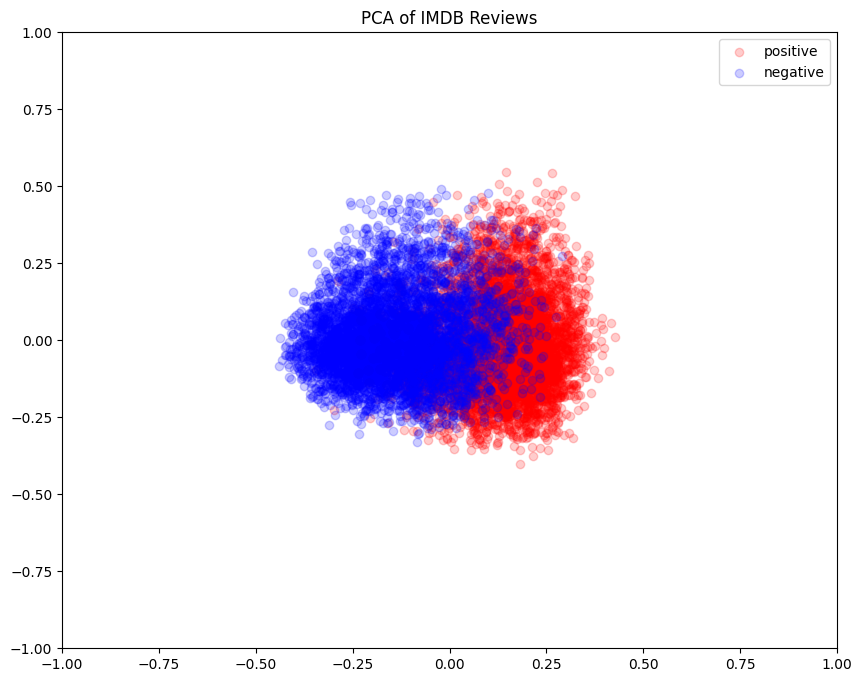

In [7]:
pca = PCA(n_components=2)
val_X_pca = pca.fit_transform(val_X)

# Create boolean masks for each class
positive_mask = np.array([label == "positive" for label in val_X_labels])
negative_mask = ~positive_mask

plt.figure(figsize=(10, 8))
# Plot each class separately
plt.scatter(val_X_pca[positive_mask, 0], val_X_pca[positive_mask, 1], 
           c='red', alpha=0.2, label='positive')
plt.scatter(val_X_pca[negative_mask, 0], val_X_pca[negative_mask, 1], 
           c='blue', alpha=0.2, label='negative')
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.legend()
plt.title("PCA of IMDB Reviews")
plt.show()

In [8]:
print_pca_stats(val_X_pca)


PC1 Statistics:
Mean: -0.000
Std: 0.183
Min: -0.439
Max: 0.426
25th percentile: -0.149
Median: 0.014
75th percentile: 0.153

PC2 Statistics:
Mean: 0.000
Std: 0.148
Min: -0.400
Max: 0.547
25th percentile: -0.105
Median: -0.016
75th percentile: 0.089


In [9]:
positive_train_df = train_df[train_df["sentiment"] == "positive"]
negative_train_df = train_df[train_df["sentiment"] == "negative"]
len(positive_train_df), len(negative_train_df)

(20022, 19877)

In [10]:
emb_pos = np.array([np.array(emb) for emb in positive_train_df["embeddings"]])
emb_neg = np.array([np.array(emb) for emb in negative_train_df["embeddings"]])

emb_all = np.concatenate([emb_pos, emb_neg])
emb_pos.shape, emb_neg.shape, emb_all.shape

((20022, 1536), (19877, 1536), (39899, 1536))

In [101]:
k = 50
Q_all, R_all = np.linalg.qr(emb_all.T)
Q_review = Q_all[:, :k]  # Shape: (d, k)
Q_review.shape

(1536, 50)

In [102]:
def remove_common_component(q, Q_common):
    # Project q onto the common review subspace
    proj = Q_common @ (Q_common.T @ q)
    return q - proj

Q_pos, R_pos = np.linalg.qr(emb_pos.T)
Q_pos_sent_res = np.array([remove_common_component(q, Q_review) for q in Q_pos.T]).T

In [103]:
Q_sentiment, R_sentiment = np.linalg.qr(Q_pos_sent_res)
v = emb_pos[0]  # Example positive review embedding, shape: (d,)
v_sentiment = v @ Q_sentiment @ Q_sentiment.T
v_common = v @ Q_review @ Q_review.T
v_other = v - (v_common + v_sentiment)

reconstruction_error = np.linalg.norm(v - (v_common + v_sentiment + v_other))
print("Reconstruction error:", reconstruction_error)

# Optionally, check orthogonality:
orthogonality = [np.dot(v_sentiment, q) for q in Q_review.T]
print("Average dot product with Q_review:", np.mean(orthogonality))

Reconstruction error: 0.0
Average dot product with Q_review: 0.02000000029776383


In [152]:
# remove the projected subspace from the validation data

alpha = 0.01
beta = 1.0
gamma = 1.0

val_X_v_sentiment = val_X @ Q_sentiment @ Q_sentiment.T
val_X_v_common = val_X @ Q_review @ Q_review.T
val_X_v_other = val_X - (val_X_v_common + val_X_v_sentiment)

val_X_v_adjusted = (val_X_v_common * beta) + (val_X_v_other * gamma) + (val_X_v_sentiment * alpha)
print("Norm difference from original:", np.linalg.norm(val_X - val_X_v_adjusted))

Norm difference from original: 99.49869505573739


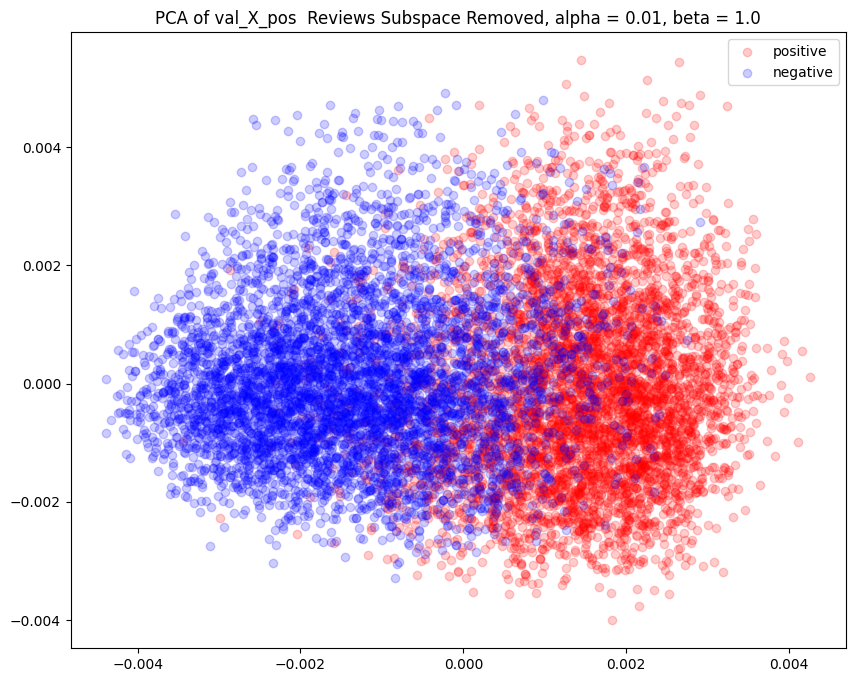

In [153]:
pca = PCA(n_components=2)
val_X_v_sentiment_removed_pca = pca.fit_transform(val_X_v_adjusted)

# Create boolean masks for each class
positive_mask = np.array([label == "positive" for label in val_X_labels])
negative_mask = ~positive_mask

plt.figure(figsize=(10, 8))
# Plot each class separately
plt.scatter(
    val_X_v_sentiment_removed_pca[positive_mask, 0],
    val_X_v_sentiment_removed_pca[positive_mask, 1],
    c="red",
    alpha=0.2,
    label="positive",
)
plt.scatter(
    val_X_v_sentiment_removed_pca[negative_mask, 0],
    val_X_v_sentiment_removed_pca[negative_mask, 1],
    c="blue",
    alpha=0.2,
    label="negative",
)
plt.legend()
plt.title(f"PCA of val_X_pos  Reviews Subspace Removed, alpha = {alpha}, beta = {beta}")
plt.show()


In [154]:

print_pca_stats(val_X_v_sentiment_removed_pca)


PC1 Statistics:
Mean: -0.000
Std: 0.002
Min: -0.004
Max: 0.004
25th percentile: -0.001
Median: 0.000
75th percentile: 0.002

PC2 Statistics:
Mean: -0.000
Std: 0.001
Min: -0.004
Max: 0.005
25th percentile: -0.001
Median: -0.000
75th percentile: 0.001


In [155]:
val_X_predictions = predict_embedding(val_X)
val_X_proj_pca_removed_predictions = predict_embedding(val_X_v_adjusted)
len(val_X_proj_pca_removed_predictions), len(val_X_predictions)

(10101, 10101)

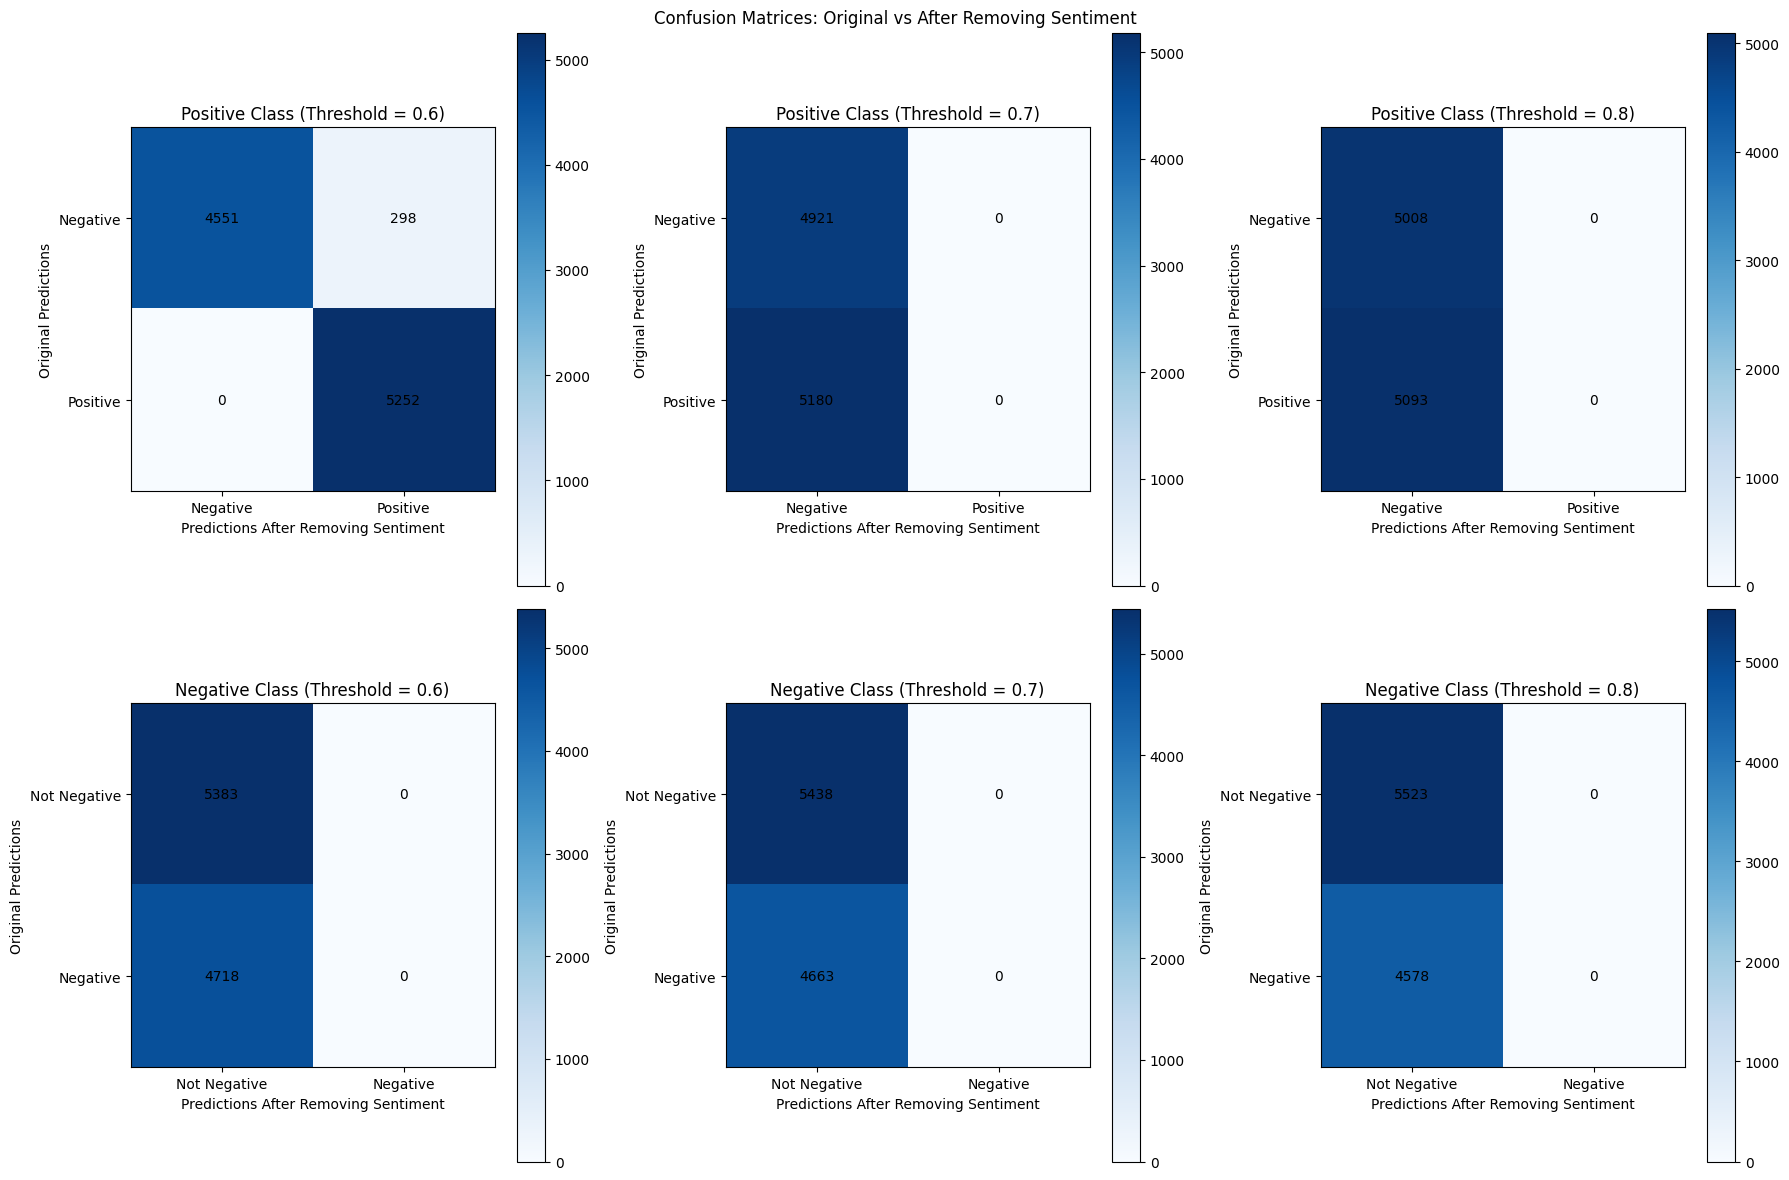

In [156]:
thresholds = [0.6, 0.7, 0.8]
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

for idx, threshold in enumerate(thresholds):
    # Get binary predictions for this threshold
    val_X_pred_binary = [1 if pred["positive"] > threshold else 0 for pred in val_X_predictions]
    val_X_removed_binary = [
        1 if pred["positive"] > threshold else 0 for pred in val_X_proj_pca_removed_predictions
    ]

    # Calculate confusion matrix metrics for positive predictions
    tp = sum((p == 1 and r == 1) for p, r in zip(val_X_pred_binary, val_X_removed_binary))
    tn = sum((p == 0 and r == 0) for p, r in zip(val_X_pred_binary, val_X_removed_binary))
    fp = sum((p == 0 and r == 1) for p, r in zip(val_X_pred_binary, val_X_removed_binary))
    fn = sum((p == 1 and r == 0) for p, r in zip(val_X_pred_binary, val_X_removed_binary))

    # Create confusion matrix for positive predictions
    cm_pos = np.array([[tn, fp], [fn, tp]])
    
    # Plot confusion matrix for positive predictions
    im = axes[0, idx].imshow(cm_pos, cmap="Blues")
    plt.colorbar(im, ax=axes[0, idx])

    # Add numbers to cells
    for i in range(2):
        for j in range(2):
            axes[0, idx].text(j, i, cm_pos[i, j], ha="center", va="center", color="black")

    # Set labels for positive predictions
    axes[0, idx].set_xticks([0, 1])
    axes[0, idx].set_yticks([0, 1])
    axes[0, idx].set_xticklabels(["Negative", "Positive"])
    axes[0, idx].set_yticklabels(["Negative", "Positive"])
    axes[0, idx].set_title(f"Positive Class (Threshold = {threshold})")
    axes[0, idx].set_ylabel("Original Predictions")
    axes[0, idx].set_xlabel("Predictions After Removing Sentiment")

    # Get binary predictions for negative class
    val_X_pred_binary_neg = [1 if pred["negative"] > threshold else 0 for pred in val_X_predictions]
    val_X_removed_binary_neg = [
        1 if pred["negative"] > threshold else 0 for pred in val_X_proj_pca_removed_predictions
    ]
    
    tp_neg = sum((p == 1 and r == 1) for p, r in zip(val_X_pred_binary_neg, val_X_removed_binary_neg))
    tn_neg = sum((p == 0 and r == 0) for p, r in zip(val_X_pred_binary_neg, val_X_removed_binary_neg))
    fp_neg = sum((p == 0 and r == 1) for p, r in zip(val_X_pred_binary_neg, val_X_removed_binary_neg))
    fn_neg = sum((p == 1 and r == 0) for p, r in zip(val_X_pred_binary_neg, val_X_removed_binary_neg))

    # Create confusion matrix for negative predictions
    cm_neg = np.array([[tn_neg, fp_neg], [fn_neg, tp_neg]])
    
    # Plot confusion matrix for negative predictions
    im = axes[1, idx].imshow(cm_neg, cmap="Blues")
    plt.colorbar(im, ax=axes[1, idx])

    # Add numbers to cells
    for i in range(2):
        for j in range(2):
            axes[1, idx].text(j, i, cm_neg[i, j], ha="center", va="center", color="black")

    # Set labels for negative predictions
    axes[1, idx].set_xticks([0, 1])
    axes[1, idx].set_yticks([0, 1])
    axes[1, idx].set_xticklabels(["Not Negative", "Negative"])
    axes[1, idx].set_yticklabels(["Not Negative", "Negative"])
    axes[1, idx].set_title(f"Negative Class (Threshold = {threshold})")
    axes[1, idx].set_ylabel("Original Predictions")
    axes[1, idx].set_xlabel("Predictions After Removing Sentiment")

plt.suptitle("Confusion Matrices: Original vs After Removing Sentiment")
plt.tight_layout()
plt.show()


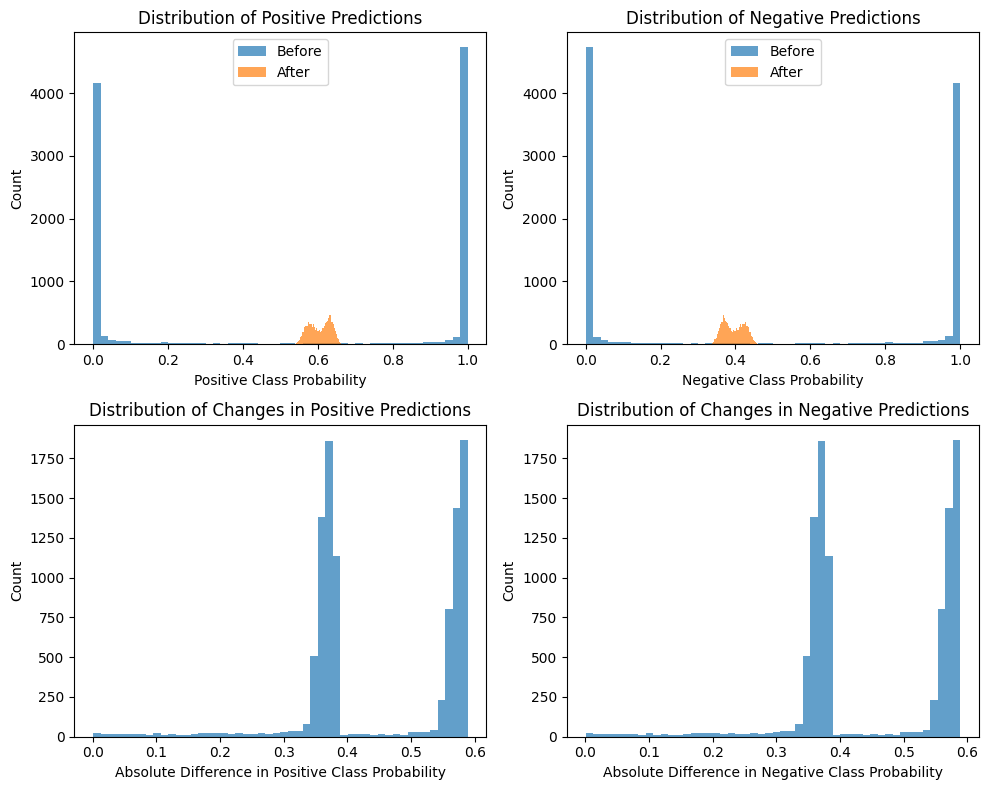

In [158]:
# Calculate absolute differences between predictions
# Calculate differences in predictions before and after removing sentiment direction
diffs_pos = []
diffs_neg = []
before_probs_pos = []
after_probs_pos = []
before_probs_neg = []
after_probs_neg = []

for pred1, pred2 in zip(val_X_predictions, val_X_proj_pca_removed_predictions):
    diff_pos = abs(pred1['positive'] - pred2['positive'])
    diff_neg = abs(pred1['negative'] - pred2['negative'])
    diffs_pos.append(diff_pos)
    diffs_neg.append(diff_neg)
    before_probs_pos.append(pred1['positive'])
    after_probs_pos.append(pred2['positive'])
    before_probs_neg.append(pred1['negative'])
    after_probs_neg.append(pred2['negative'])

plt.figure(figsize=(10, 8))

plt.subplot(2, 2, 1)
plt.hist(before_probs_pos, bins=50, alpha=0.7, label='Before')
plt.hist(after_probs_pos, bins=50, alpha=0.7, label='After')
plt.xlabel('Positive Class Probability')
plt.ylabel('Count')
plt.title('Distribution of Positive Predictions')
plt.legend()

plt.subplot(2, 2, 2)
plt.hist(before_probs_neg, bins=50, alpha=0.7, label='Before')
plt.hist(after_probs_neg, bins=50, alpha=0.7, label='After')
plt.xlabel('Negative Class Probability') 
plt.ylabel('Count')
plt.title('Distribution of Negative Predictions')
plt.legend()

plt.subplot(2, 2, 3)
plt.hist(diffs_pos, bins=50, alpha=0.7)
plt.xlabel('Absolute Difference in Positive Class Probability')
plt.ylabel('Count')
plt.title('Distribution of Changes in Positive Predictions')

plt.subplot(2, 2, 4)
plt.hist(diffs_neg, bins=50, alpha=0.7)
plt.xlabel('Absolute Difference in Negative Class Probability')
plt.ylabel('Count')
plt.title('Distribution of Changes in Negative Predictions')

plt.tight_layout()
plt.show()
